In [1]:
import astropy.units as u
import lalsimulation.gwsignal.core.waveform as wfm
from lalsimulation.gwsignal.models import gwsignal_get_waveform_generator
import matplotlib.pyplot as plt

from gw_signal_tools.waveform import (
    fd_to_td,
    td_to_fd,
    correct_for_conditioning,
    zero_pad,
    shift_signal_cyclic,
)

/Users/maxmelching/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.


In [2]:
from gw_signal_tools import PLOT_STYLE_SHEET

plt.style.use(PLOT_STYLE_SHEET)

# Fourier Transformation Capabilities of `gwsignal` (And `gw-signal-tools`)

In [3]:
f_min = 16.0 * u.Hz
f_max = 2048.0 * u.Hz
delta_f = 2**-6 * u.Hz
delta_t = 2**-12 * u.s
f_ref = f_min


wf_params = {
    'mass1': 25.0 * u.Msun,
    'mass2': 15.0 * u.Msun,
    'f22_start': f_min,
    'f_max': f_max,
    'deltaF': delta_f,
    'deltaT': delta_t,
    'f22_ref': f_ref,
    'phi_ref': 0.0 * u.rad,
    'distance': 440.0 * u.Mpc,
    'inclination': 0.0 * u.rad,
    'condition': 1,
    # 'condition': 0,
}

## Basic Functionality (TD model)

The idea is that one can easily change from time domain into frequency domain and vice versa, in the same manner that `GenerateTDWaveform` and `GenerateFDWaveform` produce equivalent output. This allows the change for arbitrary GWpy ``TimeSeries`` and ``FrequencySeries``, which might not represent waveforms (so that one cannot simply use the respective other Generate functionality).

We demonstrate this equivalence now.

In [4]:
# wf_gen = gwsignal_get_waveform_generator('SEOBNrv4PHM')  # A time domain model
wf_gen = gwsignal_get_waveform_generator('IMRPhenomXPHM')  # A frequency domain model

/Users/maxmelching/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


In [5]:
hp_f, hc_f = wfm.GenerateFDWaveform(wf_params, wf_gen)
hp_t, hc_t = wfm.GenerateTDWaveform(wf_params, wf_gen)
hp_t_padded, hc_t_padded = zero_pad(hp_t, delta_f), zero_pad(hc_t, delta_f)

hp_f_ifft, hc_f_ifft = fd_to_td(hp_f), fd_to_td(hc_f)
hp_t_fft, hc_t_fft = td_to_fd(hp_t), td_to_fd(hc_t)
# -- To increase resolution of FFT signal, use following code
# hp_t_fft, hc_t_fft = td_to_fd(hp_t_padded), td_to_fd(hc_t_padded)

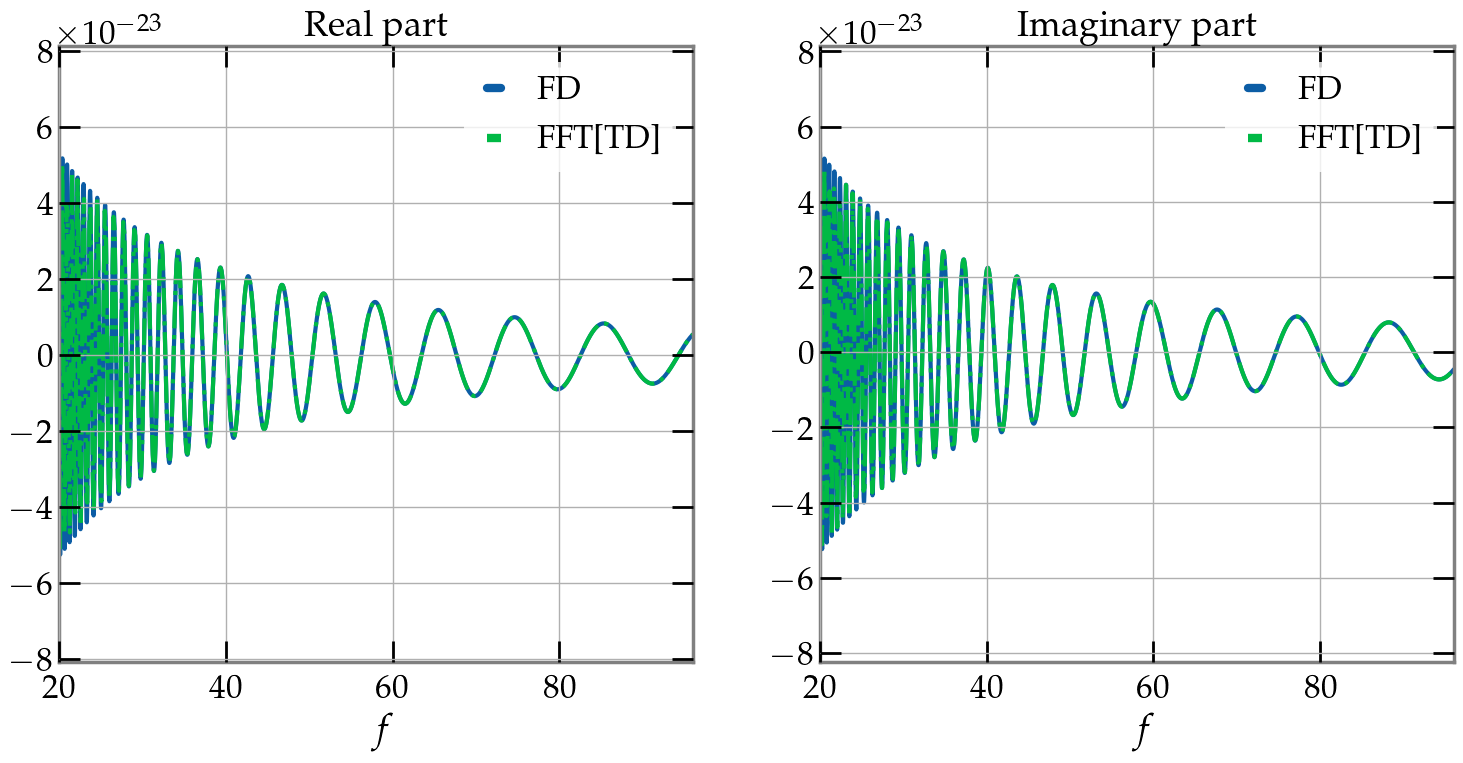

In [6]:
fig, [ax_fd_re, ax_fd_im] = plt.subplots(ncols=2, figsize=(18, 8), sharex=True)

ax_fd_re.plot(hp_f.real, label='FD')
ax_fd_re.plot(hp_t_fft.real, '-.', label='FFT[TD]')
ax_fd_re.set_xlabel(r'$f$')
ax_fd_re.set_title('Real part')
ax_fd_re.legend()

ax_fd_im.plot(hp_f.imag, label='FD')
ax_fd_im.plot(hp_t_fft.imag, '-.', label='FFT[TD]')
ax_fd_im.set_xlabel(r'$f$')
ax_fd_im.set_title('Imaginary part')
ax_fd_im.legend()

plt.xlim(20, 96)

plt.show()

***Note:*** these signals agree perfectly, but are sampled at different `df`. The linear interpolation then can make it look like they might not be perfectly equal. To remove this effect, if present, please enable the line that makes use of `zero_pad` in the definition of `hp_t_fft, hc_t_fft`.

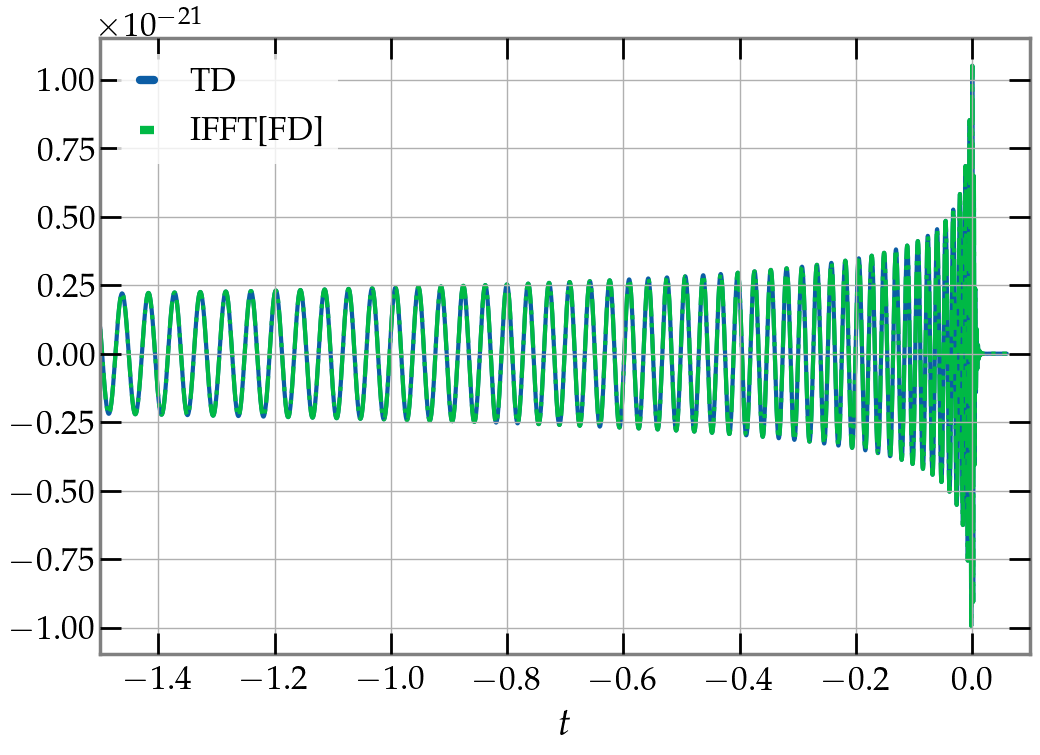

In [7]:
fig, ax_td = plt.subplots(figsize=(12, 8), sharex=True)

ax_td.plot(hp_t, label='TD')
ax_td.plot(hp_f_ifft, '-.', label='IFFT[FD]')
ax_td.set_xlabel(r'$t$')
ax_td.legend()
plt.xlim(-1.5, 0.1)

plt.show()

## Basic Functionality (FD model)

In [8]:
wf_gen = gwsignal_get_waveform_generator('IMRPhenomXPHM')  # A frequency domain model
# wf_gen = gwsignal_get_waveform_generator('TaylorF2')  # Versatile model

/Users/maxmelching/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


In [9]:
hp_f, hc_f = wfm.GenerateFDWaveform(wf_params, wf_gen)
hp_t, hc_t = wfm.GenerateTDWaveform(wf_params, wf_gen)
hp_t_padded, hc_t_padded = zero_pad(hp_t, delta_f), zero_pad(hc_t, delta_f)

hp_f_ifft, hc_f_ifft = fd_to_td(hp_f), fd_to_td(hc_f)
hp_t_fft, hc_t_fft = td_to_fd(hp_t), td_to_fd(hc_t)
# -- To increase resolution of FFT signal, use following code
# hp_t_fft, hc_t_fft = td_to_fd(hp_t_padded), td_to_fd(hc_t_padded)

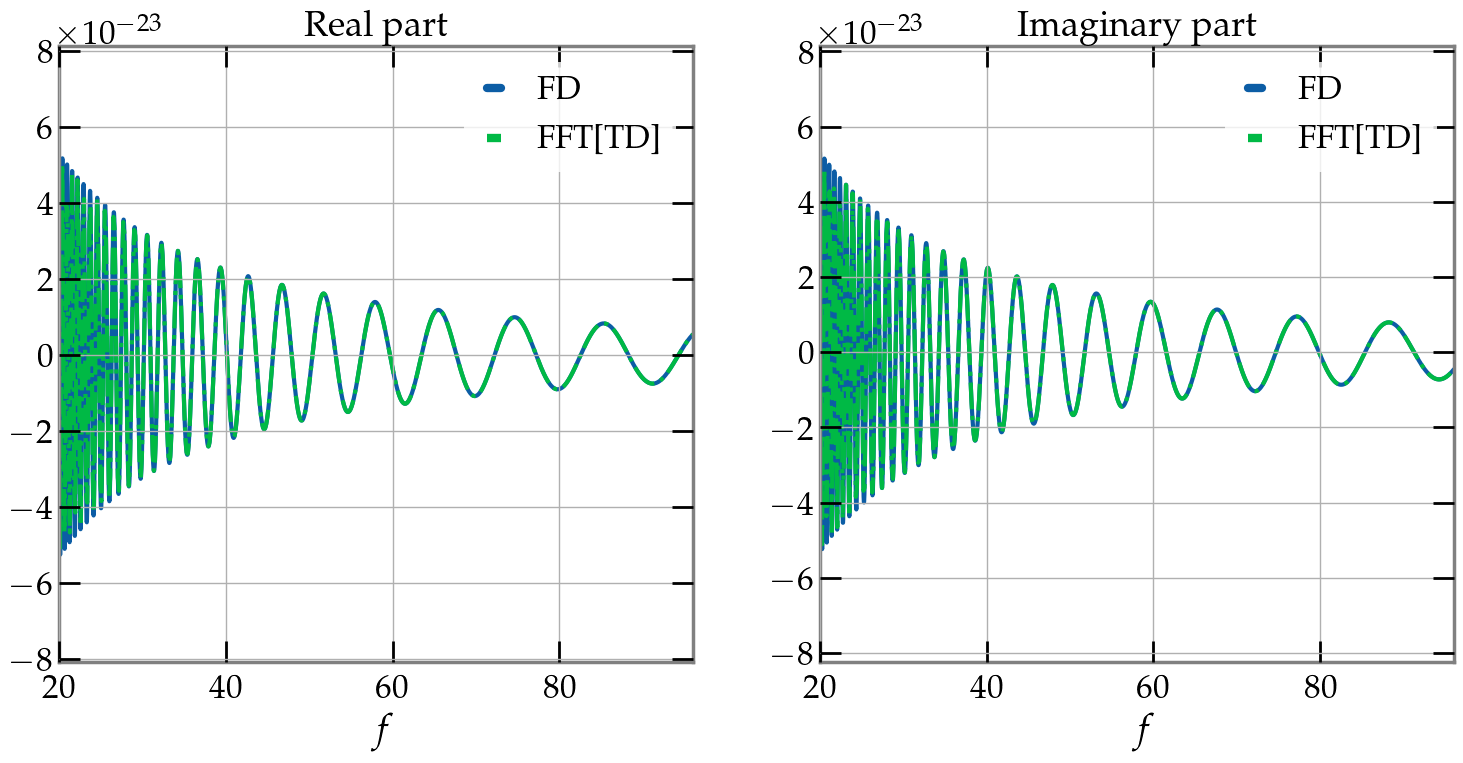

In [10]:
fig, [ax_fd_re, ax_fd_im] = plt.subplots(ncols=2, figsize=(18, 8), sharex=True)

ax_fd_re.plot(hp_f.real, label='FD')
ax_fd_re.plot(hp_t_fft.real, '-.', label='FFT[TD]')
ax_fd_re.set_xlabel(r'$f$')
ax_fd_re.set_title('Real part')
ax_fd_re.legend()

ax_fd_im.plot(hp_f.imag, label='FD')
ax_fd_im.plot(hp_t_fft.imag, '-.', label='FFT[TD]')
ax_fd_im.set_xlabel(r'$f$')
ax_fd_im.set_title('Imaginary part')
ax_fd_im.legend()

plt.xlim(20, 96)

plt.show()

***Note:*** these signals agree perfectly, but are sampled at different `df`. The linear interpolation performed during plotting can make it look like they are not really equal. To remove this effect, please enable the line that makes use of `zero_pad` in the definition of `hp_t_fft, hc_t_fft`.

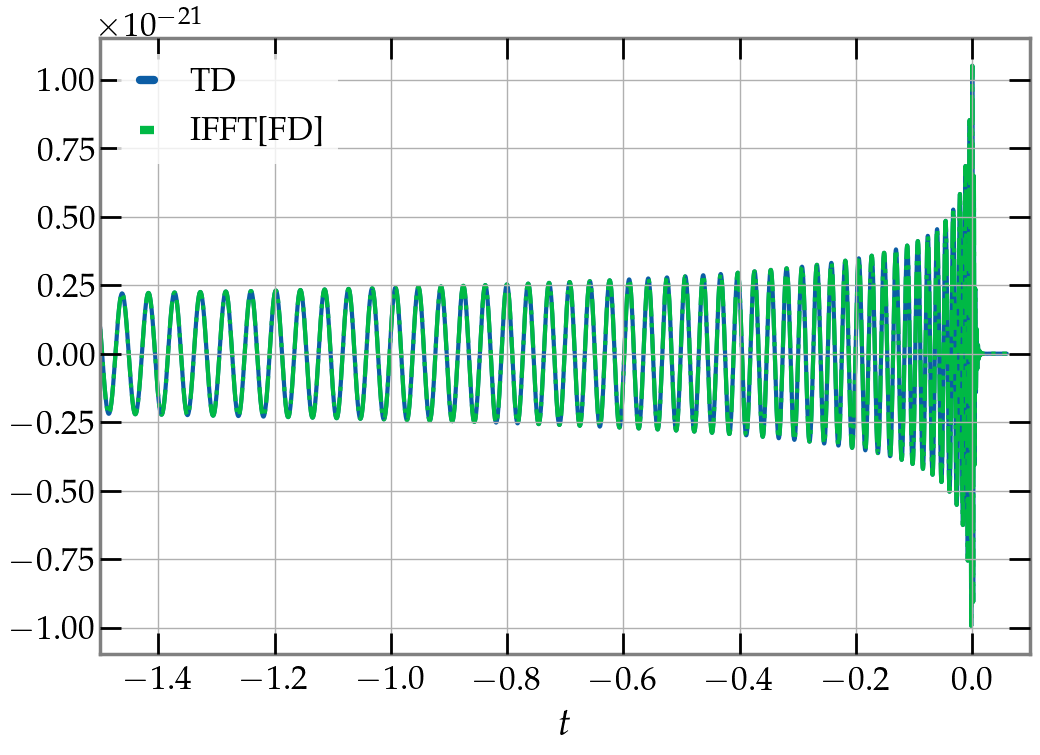

In [11]:
fig, ax_td = plt.subplots(figsize=(12, 8))

ax_td.plot(hp_t, label='TD')
ax_td.plot(hp_f_ifft, '-.', label='IFFT[FD]')
ax_td.set_xlabel(r'$t$')
ax_td.legend()

plt.xlim(-1.5, 0.1)

plt.show()

## The Impact Of Conditioning

To safeguard against potential shortcomings of transforming signals that have short (i.e. non-differentiable) cutoffs and to avoid wrap-around of signals, a set of procedures that are summarized under the term "conditioning" can be applied.
Here we show the impact of this procedure on the way Fourier transforms work.

In [12]:
hp_f_no_cond, hc_f_no_cond = wfm.GenerateFDWaveform(
    wf_params | {'condition': 0}, wf_gen
)
hp_f_w_cond, hc_f_w_cond = wfm.GenerateFDWaveform(wf_params | {'condition': 1}, wf_gen)
# -- Equivalent for what we want to show: hp_f_w_cond, hc_f_w_cond = hp_t_fft, hc_t_fft

hp_f_w_cond_corrected = correct_for_conditioning(hp_f_w_cond)
hc_f_w_cond_corrected = correct_for_conditioning(hc_f_w_cond)

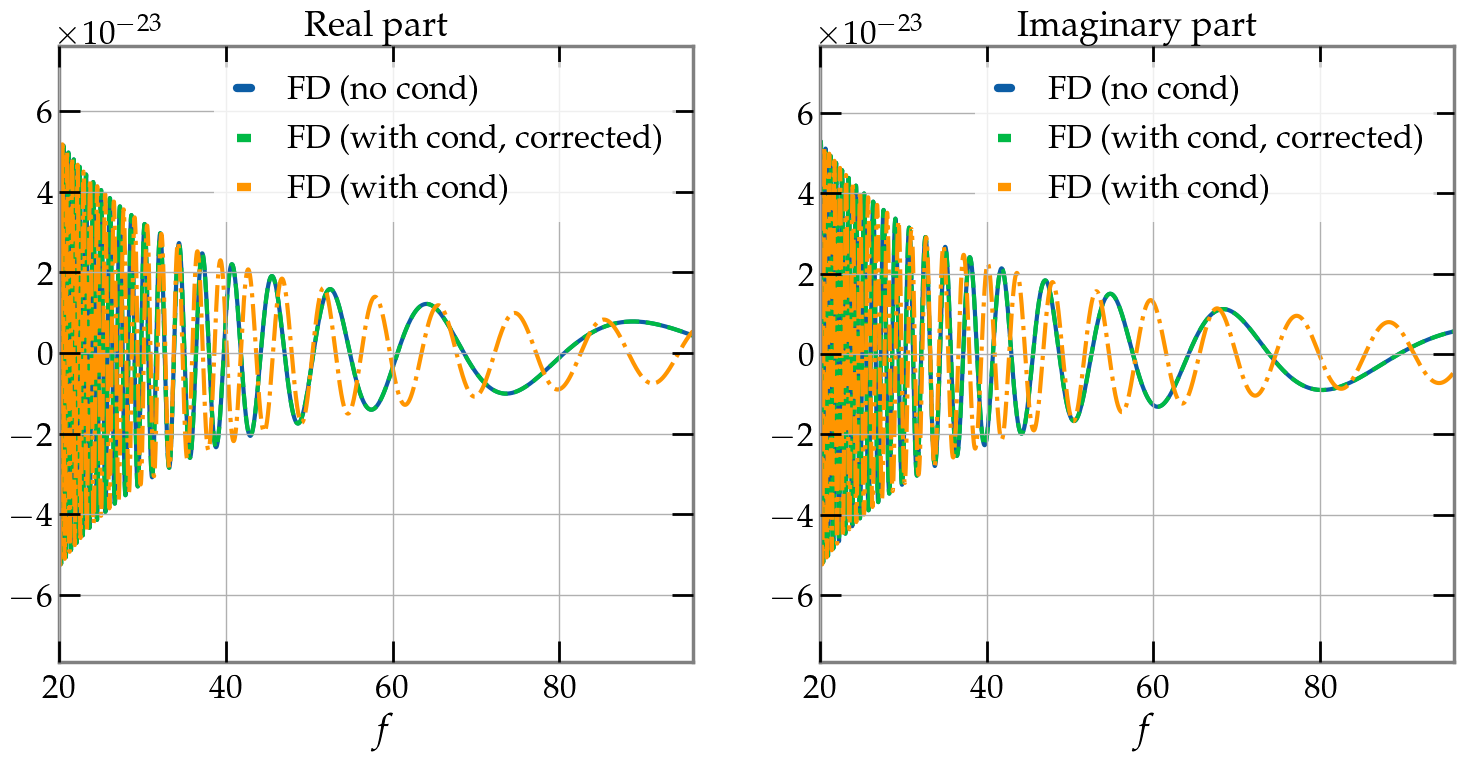

In [13]:
fig, [ax_fd_re, ax_fd_im] = plt.subplots(ncols=2, figsize=(18, 8), sharex=True)

ax_fd_re.plot(hp_f_no_cond.real, label='FD (no cond)')
ax_fd_re.plot(hp_f_w_cond_corrected.real, '--', label='FD (with cond, corrected)')
ax_fd_re.plot(hp_f_w_cond.real, '-.', label='FD (with cond)')
ax_fd_re.set_xlabel(r'$f$')
ax_fd_re.set_title('Real part')
ax_fd_re.legend()

ax_fd_im.plot(hp_f_no_cond.imag, label='FD (no cond)')
ax_fd_im.plot(hp_f_w_cond_corrected.imag, '--', label='FD (with cond, corrected)')
ax_fd_im.plot(hp_f_w_cond.imag, '-.', label='FD (with cond)')
ax_fd_im.set_xlabel(r'$f$')
ax_fd_im.set_title('Imaginary part')
ax_fd_im.legend()

plt.xlim(20, 96)

plt.show()

Everything as expected:

- conditioned FD waveform (green) is different from other waveforms because it contains a phase factor to correct for wrap-around in time domain (see below)

- unconditioned FD waveform (blue) and conditioned FD waveform with `correct_for_conditioning` applied (orange) have no differential phase factor (some differences might still be there due to other conditioning steps, but this one is removed)


Let us now look at these waveforms after an inverse Fourier transformation:

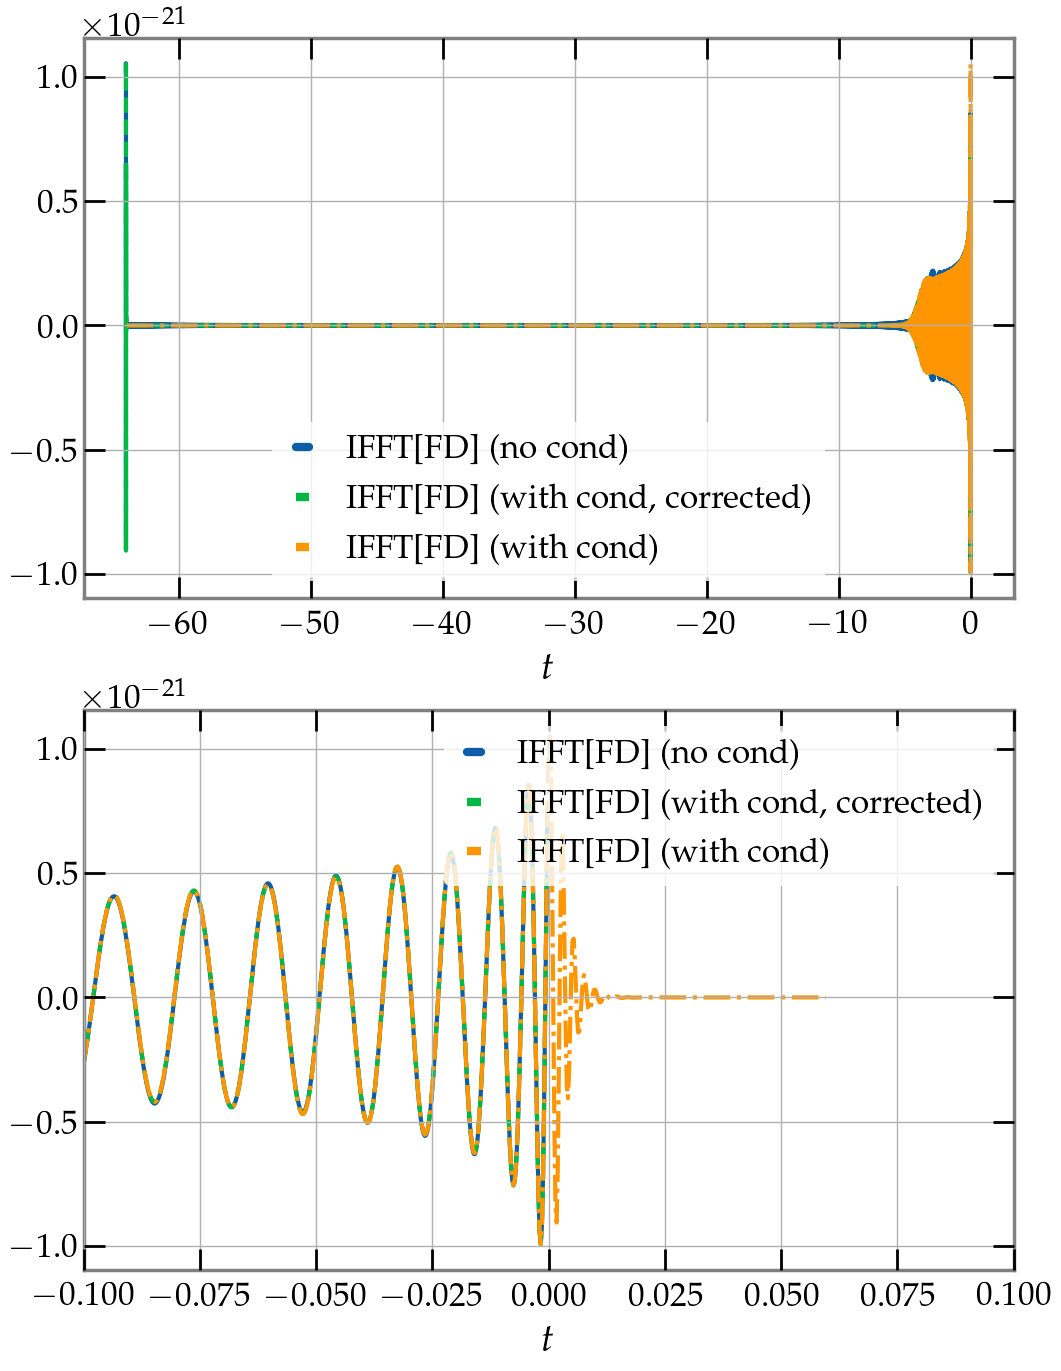

In [14]:
fig, [ax_td, ax_td_zoom] = plt.subplots(figsize=(12, 16), nrows=2)

ax_td.plot(fd_to_td(hp_f_no_cond), label='IFFT[FD] (no cond)')
ax_td.plot(
    fd_to_td(hp_f_w_cond_corrected), '--', label='IFFT[FD] (with cond, corrected)'
)
ax_td.plot(fd_to_td(hp_f_w_cond), '-.', label='IFFT[FD] (with cond)')
ax_td.set_xlabel(r'$t$')
ax_td.legend()


ax_td_zoom.plot(fd_to_td(hp_f_no_cond), label='IFFT[FD] (no cond)')
ax_td_zoom.plot(
    fd_to_td(hp_f_w_cond_corrected), '--', label='IFFT[FD] (with cond, corrected)'
)
ax_td_zoom.plot(fd_to_td(hp_f_w_cond), '-.', label='IFFT[FD] (with cond)')
ax_td_zoom.set_xlabel(r'$t$')
ax_td_zoom.legend()

# plt.xlim(-1.5, 0.1)
plt.xlim(-0.1, 0.1)

plt.show()

Everything as expected:

- conditioned FD waveform (green) produces sensible TD waveform

- unconditioned FD waveform (blue) shows wrap-around in TD waveform

- conditioned FD waveform with `correct_for_conditioning` applied (orange) also shows wrap-around in TD waveform, i.e. it is consistent with unconditioned waveform

## Bonus: Conventions

***Note:*** this section is for people who are interested in details of which Fourier transform LAL applies. The default `'wrap'` convention of the routines should be used in any cases where you do not exactly what you are doing, because the same convention is enforced by other functions like the conditioning routines!

There is a `convention` argument in the routines, which we will now explain. The idea is that there is no unique way of incorporating information about the starting time $t_0$ of a signal into its Fourier transform. Typically, they enter in the actual via a phase factor like $\exp(-2\pi i f t_0)$. In case of GW data analysis, however, where starting times are often given in the GPS format as numbers like $1192529720$ s, the use of such a phase factor is not feasible (corresponding oscillations are too large and $t_0 > $ duration is problematic as well).

What we can choose to do instead is treat every signal as if it had starting time $t_0 = 0$ (i.e. as if the first samples represents time $0$), while storing the actual starting time separately. This way, we can still convert in a well-defined manner from TD to FD and vice versa.

In [15]:
shift = 2 * u.s
hp_t_shifted = hp_t_padded.copy()
hp_t_shifted.t0 = hp_t_shifted.t0 + shift  # What shift_signal function would do

hp_t_shifted_fft = td_to_fd(hp_t_shifted)

In [16]:
hp_t_fft_v2 = td_to_fd(hp_t_padded, convention='unwrap')
hp_t_shifted_fft_v2 = td_to_fd(hp_t_shifted, convention='unwrap')

For both conventions, the epochs (starting times) change in the same manner:

In [17]:
print(hp_t_fft.epoch, hp_t_shifted_fft.epoch)
print(hp_t_fft_v2.epoch, hp_t_shifted_fft_v2.epoch)

-7.584472655992869 -61.940185546991415
-63.94018554700597 -61.940185546991415


However, looking at the different frequency domain signals:

/Users/maxmelching/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/maxmelching/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


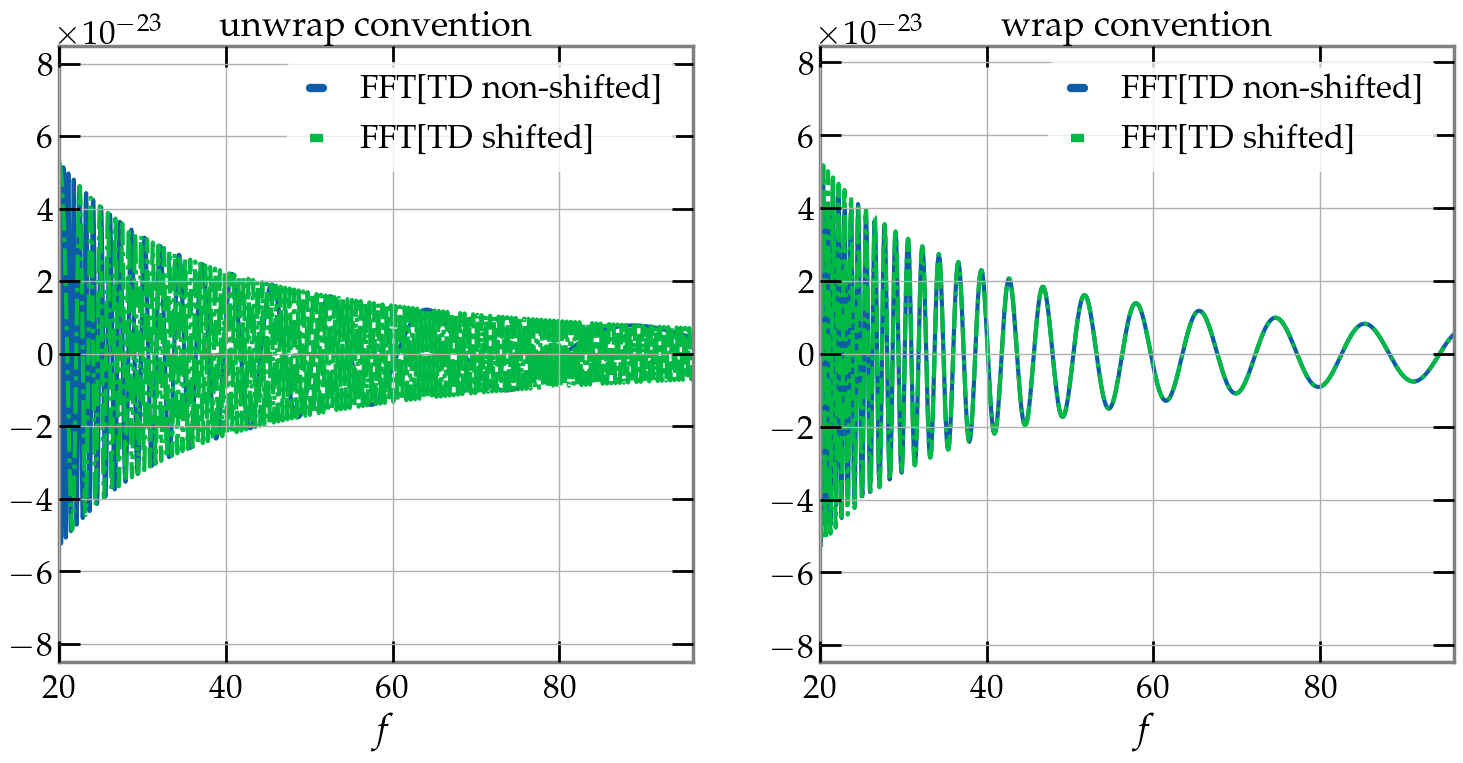

In [18]:
fig, [ax_fd_1, ax_fd_2] = plt.subplots(ncols=2, figsize=(18, 8), sharex=True)

ax_fd_1.plot(hp_t_fft_v2, label='FFT[TD non-shifted]')
ax_fd_1.plot(hp_t_shifted_fft_v2, '-.', label='FFT[TD shifted]')
ax_fd_1.set_xlabel(r'$f$')
ax_fd_1.set_title('unwrap convention')
ax_fd_1.legend()

ax_fd_2.plot(hp_t_fft, label='FFT[TD non-shifted]')
ax_fd_2.plot(hp_t_shifted_fft, '-.', label='FFT[TD shifted]')
ax_fd_2.set_xlabel(r'$f$')
ax_fd_2.set_title('wrap convention')
ax_fd_2.legend()

plt.xlim(20, 96)

plt.show()

We see difference in signal for `'unwrap'` convention, but not in `'wrap'` convention.

Regarding the rapid oscillation in the right-hand panel, note that a frequency of 2 Hz over a range of 60s corresponds to 120 oscillations. This is why the orange plot in the right panel should be exactly what we expect, a time-shift by 2 s in frequency domain is analogous to a frequency shift by 2 Hz in time domain.

We can encapsulate differences in the conventions in a single plot:

In [19]:
signal = hp_t

unpadded_duration = hp_t.duration
duration = signal.duration
t_shift = 0.5 * u.s
shifted_signal = signal.copy()
shifted_signal.t0 = shifted_signal.t0 + t_shift

rolled_signal = shift_signal_cyclic(signal, t_shift)

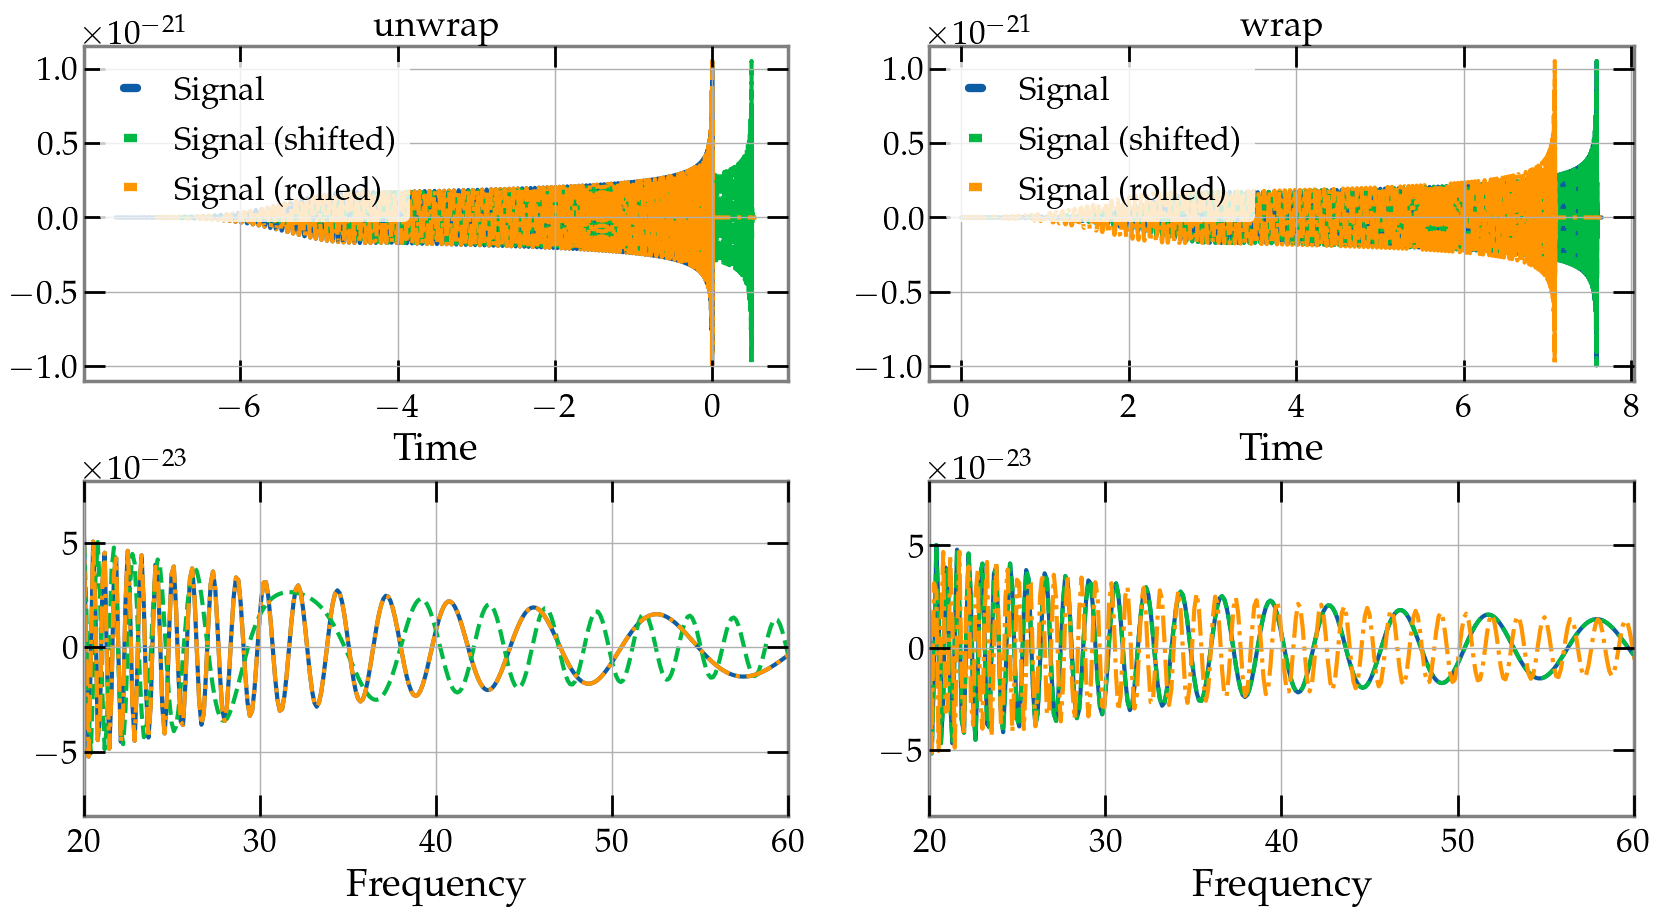

In [20]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=2, ncols=2)

ax = ax.T  # Determines whether time plots are in same row or column

ax[0, 0].plot(signal, '-', label='Signal')
ax[0, 0].plot(shifted_signal, '--', label='Signal (shifted)')
ax[0, 0].plot(rolled_signal, '-.', label='Signal (rolled)')

ax[0, 0].legend(loc='upper left')
ax[0, 0].set_xlabel('Time')
# ax[0, 0].set_xlim(-duration.value, 0.1 + t_shift.value)
# ax[0, 0].set_xlim(-unpadded_duration.value, 0.1 + t_shift.value)


ax[1, 0].plot(signal.times - signal.t0, signal.value, '-', label='Signal')
ax[1, 0].plot(
    signal.times - signal.t0, shifted_signal.value, '--', label='Signal (shifted)'
)
ax[1, 0].plot(
    signal.times - signal.t0, rolled_signal.value, '-.', label='Signal (rolled)'
)

ax[1, 0].legend(loc='upper left')
ax[1, 0].set_xlabel('Time')
# ax[1, 0].set_xlim(-signal.t0.value - duration.value, -signal.t0.value + 0.1 + t_shift.value)
# ax[1, 0].set_xlim(-signal.t0.value - unpadded_duration.value, -signal.t0.value + 0.1 + t_shift.value)


ax[0, 1].plot(td_to_fd(signal, convention='unwrap'), '-')
ax[0, 1].plot(td_to_fd(shifted_signal, convention='unwrap'), '--')
ax[0, 1].plot(td_to_fd(rolled_signal, convention='unwrap'), '-.')

ax[0, 1].set_xlabel('Frequency')
ax[0, 1].set_xlim(20, 60)


ax[1, 1].plot(td_to_fd(signal), '-')
ax[1, 1].plot(td_to_fd(shifted_signal), '--')
ax[1, 1].plot(td_to_fd(rolled_signal), '-.')

ax[1, 1].set_xlabel('Frequency')
ax[1, 1].set_xlim(20, 60)


ax[0, 0].set_title('unwrap')
ax[1, 0].set_title('wrap')

plt.subplots_adjust(hspace=0.3)

plt.show()

### Problems With Convention Mixing

Here we will show some effects that can occur when using the Fourier transform with convention `'unwrap'` to waveforms generated using the `'wrap'` convention.

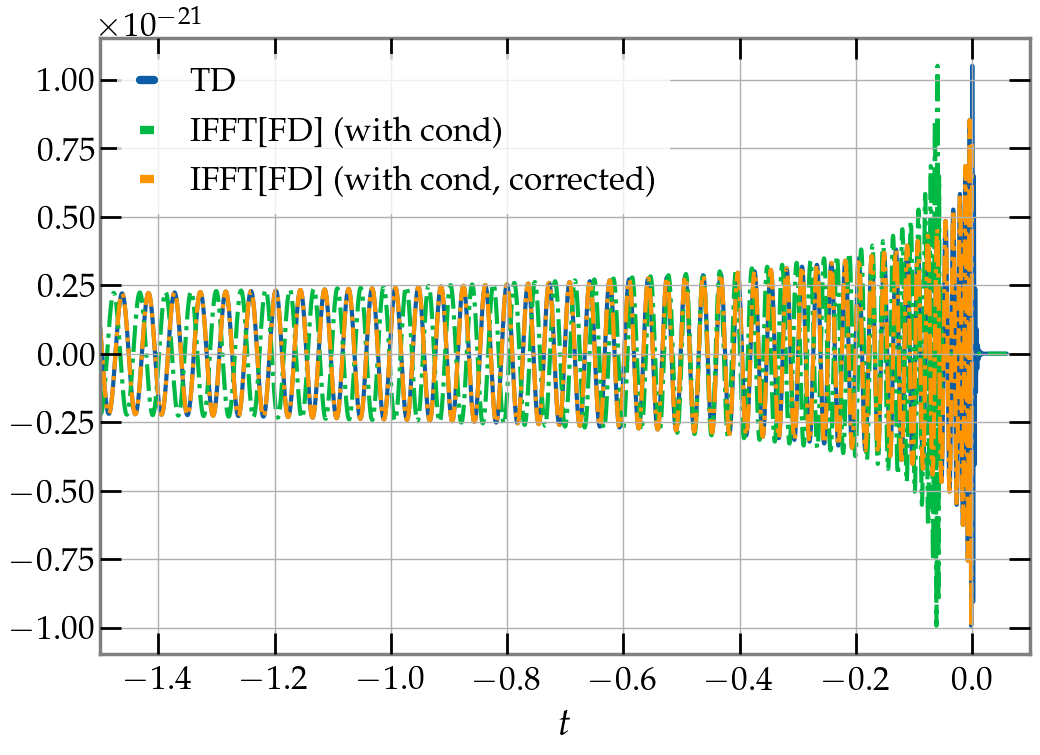

In [21]:
fig, ax_td = plt.subplots(figsize=(12, 8))

ax_td.plot(hp_t, label='TD')
ax_td.plot(fd_to_td(hp_f, convention='unwrap'), '-.', label='IFFT[FD] (with cond)')
ax_td.plot(
    fd_to_td(correct_for_conditioning(hp_f), convention='unwrap'),
    '-.',
    label='IFFT[FD] (with cond, corrected)',
)
ax_td.set_xlabel(r'$t$')
ax_td.legend()

plt.xlim(-1.5, 0.1)

plt.show()

Problem: cyclic time shift is applied during conditioning to shift samples from beginning of signal to end; but this works differently in different conventions, one requires multiplication with phase factor related to this amount and other does not.

Correcting for conditioning is able to remove the wrong time shift, but we have the usual problem of wrapping again (as before when applying this function).